In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
np.random.seed(1000)

In [4]:
def create_data():
    np.random.seed(1000)
    array_A = np.random.randn(1000, 10)
    x_bar_variable = np.zeros(10)
    for i in range(10):
        if (i+1) % 2 == 0:
            x_bar_variable[i] = np.random.uniform(low=i+1, high=i+2)
        else:
            x_bar_variable[i] = np.random.uniform(low=-(i+2), high=-(i+1))
    x_bar_variable = np.array(x_bar_variable)
    x_bar_variable = x_bar_variable.reshape(10, 1)
    epsilon_variable = np.random.randn(1000, 1)
    output_y = np.add(np.dot(array_A, x_bar_variable), epsilon_variable)
    return array_A, x_bar_variable, output_y

In [5]:
def evalf(lambd, A, x, y):
    temp = np.subtract(np.dot(A,x),y)
    fval = np.multiply((lambd/2), np.dot(x.T,x)) + 0.5*np.linalg.norm(temp,2)**2
    return fval

In [6]:
def evalg(lambd_value, array_A, x_variable, output_y):
    temp = np.dot(array_A, x_variable) - output_y
    grad = np.add(np.multiply(lambd_value, x_variable), np.dot(array_A.T, temp))
    return grad

In [7]:
def evalh(lambd_value, array_A, x_variable):
    hess = np.multiply(lambd_value, np.identity(array_A.shape[1])) + np.matmul(array_A.T, array_A)
    return hess

In [8]:
def compute_D_k_newton(lambd_value, array_A, x_variable):
    d = np.linalg.inv(evalh(lambd_value, array_A, x_variable))
    return d

In [9]:
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [10]:
def compute_steplength_backtracking_scaled_direction(lambd_value, array_A, x_variable, output_y, gradf, D_k, alpha_start, rho, gamma):
    alpha = alpha_start
    p_k = -np.dot(D_k, gradf)
    while evalf(lambd_value, array_A, np.add(x_variable, np.multiply(alpha, p_k)), output_y) > np.multiply(gamma * alpha, np.dot(gradf.T, p_k)) + evalf(lambd_value, array_A, x_variable, output_y):
        alpha = rho * alpha
    return alpha

In [11]:
def find_minimizer_Newtonmethod(lambd_value, start_x, array_A, output_y, tol, line_search_type, *args):
    x_variable = start_x
    g_x = evalg(lambd_value, array_A, x_variable, output_y)
    x_array = [x_variable]
    f_array = [evalf(lambd_value, array_A, x_variable, output_y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args) < 3:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    while (np.linalg.norm(g_x) > tol):
        d_k = compute_D_k_newton(lambd_value, array_A, x_variable)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(lambd_value, array_A, x_variable, output_y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')
        x_variable = np.subtract(x_variable, np.multiply(step_length, np.dot(d_k, g_x)))
        k += 1
        g_x = evalg(lambd_value, array_A, x_variable, output_y)
        x_array.append(x_variable)
        f_array.append(evalf(lambd_value, array_A, x_variable, output_y))
        if k % 4000 == 0:
            print('iter:', k, ' x:', x_variable, ' f(x):', evalf(lambd_value, array_A, x_variable, output_y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

In [12]:
A, x_bar, y = create_data()

In [13]:
def find_minimizer_BFGS(lambd_value, start_x_variable, array_A, output_y, tol_value, line_search_type, *args):
    x_variable = start_x_variable
    g_x = evalg(lambd_value, array_A, x_variable, output_y)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args) < 3:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x_variable]
    f_array = [evalf(lambd_value, array_A, x_variable, output_y)]

    while (np.linalg.norm(g_x) > tol_value):
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(lambd_value, array_A, x_variable, output_y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')
        x_next = np.add(x_variable, np.multiply(step_length, p))
        s_k = x_next - x_variable
        y_k = evalg(lambd_value, array_A, x_next, output_y) - g_x
        mu_k = 1.0 / np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k, np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1
        x_variable = x_next
        g_x = evalg(lambd_value, array_A, x_variable, output_y)
        x_array.append(x_variable)
        f_array.append(evalf(lambd_value, array_A, x_variable, output_y))
        if k % 4000 == 0:
            print('iter:', k, ' x:', x_variable, ' f(x):', evalf(lambd_value, array_A, x_variable, output_y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

#Q-1

In the preceding task, the Hessian matrix, denoted as $ A^TA$, may not possess the essential property of invertibility. This issue arises due to various factors, such as insufficient data or high collinearity among features, leading to a lack of full rank or ill-conditioning in $A^TA$. Consequently, the absence of a reliable inverse for $A^TA$ can hinder optimization algorithms' convergence or render their results unreliable.

To address this challenge, a regularization term is introduced, augmenting the Hessian with $\lambda I$, where $\lambda$ denotes a positive constant and $I$ represents the identity matrix. This addition ensures that the resulting matrix, $A^TA+\lambda I$, is always invertible, regardless of the specific properties of $A^TA$.

The significance of this regularization lies in two key aspects:

**Assurance of Positive Definiteness:** While $A^TA$ may lack positive definiteness, the addition of $\lambda I$ rectifies this issue. By introducing positive diagonal elements, $\lambda I$ guarantees that $A^TA+\lambda I$ becomes positive definite, thereby ensuring numerical stability and facilitating reliable optimization.

**Guaranteed Invertibility:** With $A^TA+\lambda I$ being positive definite, its invertibility is assured. This ensures that the Hessian matrix possesses a well-defined inverse, enabling optimization algorithms to converge effectively and produce reliable results.

Moreover, beyond its role in ensuring invertibility, the regularization term \$lambda I$ offers additional benefits. By controlling the growth of parameter magnitudes during optimization, it promotes smoother convergence, aids in model generalization, and mitigates the risk of overfitting, thereby enhancing the overall robustness and performance of optimization algorithms.

In essence, the incorporation of the regularization term $\lambda I$ not only addresses the challenge of Hessian invertibility but also contributes to the optimization process's stability, reliability, and regularization benefits, ultimately improving the efficacy of optimization algorithms in various contexts.


In [14]:
start_xs = []
for i in range(10):
  start_xs.append([0])
start_xs = np.array(start_xs)
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
lambda_values = [0.001, 0.01, 0.1, 1.0]
x_array_newton = [[] for _ in range(len(lambda_values))]
iters_newton = [0 for _ in range(len(lambda_values))]
f_array_newton = [[] for _ in range(len(lambda_values))]
times_newton = [0 for _ in range(len(lambda_values))]
x_array_bfgs = [[] for _ in range(len(lambda_values))]
iters_bfgs  = [0 for _ in range(len(lambda_values))]
f_array_bfgs = [[] for _ in range(len(lambda_values))]
times_bfgs = [0 for _ in range(len(lambda_values))]
for i in range(len(lambda_values)):
    start_time = timer()
    x_array_newton[i], f_array_newton[i], iters_newton[i] = find_minimizer_Newtonmethod(lambda_values[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_newton[i] = end_time - start_time
    print(f'For lambda = {lambda_values[i]}:')
    print(f"Time taken to find optimal x* by Newton's method for lambda = {lambda_values[i]}: {times_newton[i]}\nIterations: {iters_newton[i]}")
    start_time = timer()
    x_array_bfgs[i], f_array_bfgs[i], iters_bfgs[i]  = find_minimizer_BFGS(lambda_values[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_bfgs[i] = end_time - start_time
    print(f"Time taken to find optimal x* by BFGS method for lambda = {lambda_values[i]}: {times_bfgs[i]}\nIterations: {iters_bfgs[i]}")
    print('')
print()
print(f'Actual x_bar: {x_bar.reshape(1,-1)}')
print('')
x_opt_newton = [x_array_newton[i][-1] for i in range(len(lambda_values))]
x_opt_bfgs = [x_array_bfgs[i][-1] for i in range(len(lambda_values))]


For lambda = 0.001:
Time taken to find optimal x* by Newton's method for lambda = 0.001: 0.02755089499987662
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.001: 0.029202151999925263
Iterations: 18

For lambda = 0.01:
Time taken to find optimal x* by Newton's method for lambda = 0.01: 0.0023946110004544607
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.01: 0.027018085999770847
Iterations: 18

For lambda = 0.1:
Time taken to find optimal x* by Newton's method for lambda = 0.1: 0.002877166999496694
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.1: 0.028331122000054165
Iterations: 18

For lambda = 1.0:
Time taken to find optimal x* by Newton's method for lambda = 1.0: 0.0024232619998656446
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 1.0: 0.024913370999456674
Iterations: 18


Actual x_bar: [[-1.06258705  2.94307072 -3.34150552  4.58252615 -5.75947573  6.93512469
  -7.61893094  8.1681

 **Graph of the values $log(||x^k - x^*||_2$)**

<ipython-input-15-d82722c67e74>:5: RuntimeWarning: divide by zero encountered in log
  plot_x[i].append(np.log(np.linalg.norm(x_array_newton[i][j] - x_opt_newton[i])))


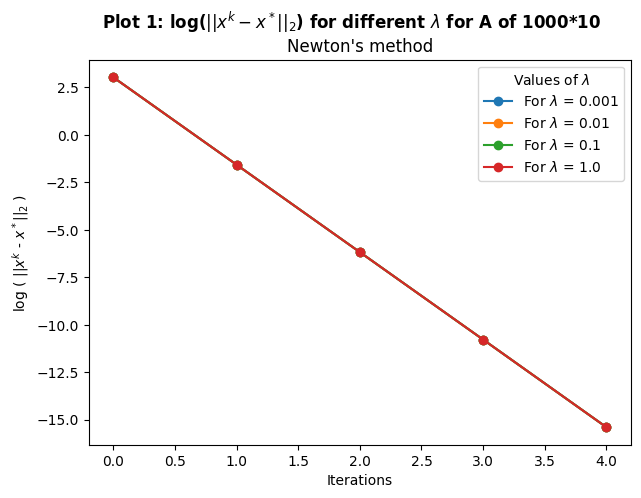

In [15]:
x_opt_newton = [x_array_newton[i][-1] for i in range(len(lambda_values))]
plot_x = [[] for _ in range(len(lambda_values))]
for i in range(len(lambda_values)):
    for j in range(len(x_array_newton[i])):
        plot_x[i].append(np.log(np.linalg.norm(x_array_newton[i][j] - x_opt_newton[i])))
### Plotting ###
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle("Plot 1: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight='bold')
for i in range(len(lambda_values)):
    ax.plot(np.arange(len(x_array_newton[i])), plot_x[i], 'o-', label=f"For $\lambda$ = {lambda_values[i]}")
ax.set_title("Newton's method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title='Values of $\lambda$')

**Graph of the values $log(||f(x^k) - f(x^*)||_2)$**

<ipython-input-16-f4c57f4b17ab>:5: RuntimeWarning: divide by zero encountered in log
  plot_fx[i].append(np.log(np.linalg.norm(f_array_newton[i][j] - f_opt_newton[i])))


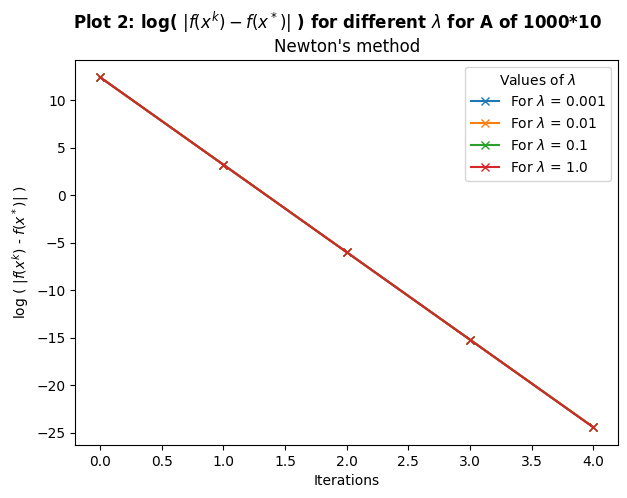

In [16]:
f_opt_newton = [f_array_newton[i][-1] for i in range(len(lambda_values))]
plot_fx = [[] for _ in range(len(lambda_values))]
for i in range(len(lambda_values)):
    for j in range(len(f_array_newton[i])):
        plot_fx[i].append(np.log(np.linalg.norm(f_array_newton[i][j] - f_opt_newton[i])))
## Plotting ##
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle("Plot 2: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight='bold')
for i in range(len(lambda_values)):
    ax.plot(np.arange(len(f_array_newton[i])), plot_fx[i], 'x-', label=f"For $\lambda$ = {lambda_values[i]}")
ax.set_title("Newton's method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x^*)$| )")
ax.legend(title='Values of $\lambda$')


**Question 4.**

$x^*$ and $\bar{x}$ are nearly identical within the specified error precision. The optimal solution $x^*$ remains consistent for both Newton's and BFGS methods across all given starting points.

The plot depicting $log(||x^k-x^*||)$ against iterations for Newton's and BFGS methods exhibits Q-linear behavior for all provided starting points. However, Newton's method demonstrates Q-linear convergence from the outset, whereas BFGS method achieves Q-linear convergence after a few initial iterations.

Similarly, the plot illustrating $log(|f(x^k)-f(x^*)|)$ against iterations for Newton's and BFGS methods mirrors the behavior observed in the plot of $log(||x^k-x^*||)$ against iterations, albeit with differing scaling on both axes.

Comparing the two methods, Newton's method proves to be faster than BFGS method due to its Q-linear convergence right from the beginning, whereas BFGS method achieves Q-linear convergence after a few initial iterations.

<ipython-input-25-71fe4f8444cb>:5: RuntimeWarning: divide by zero encountered in log
  plot_x_bfgs2[i].append(np.log(np.linalg.norm(x_array_bfgs[i][j] - x_opt_bfgs[i])))


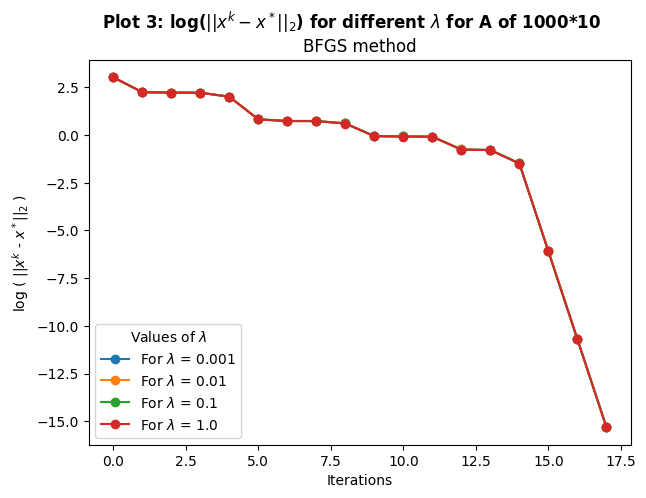

In [25]:
x_opt_bfgs2 = [x_array_bfgs[i][-1] for i in range(len(lambda_values))]
plot_x_bfgs2 = [[] for _ in range(len(lambda_values))]
for i in range(len(lambda_values)):
    for j in range(len(x_array_bfgs[i])):
        plot_x_bfgs2[i].append(np.log(np.linalg.norm(x_array_bfgs[i][j] - x_opt_bfgs[i])))
###Plotting###
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 3: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_values)):
    ax.plot(np.arange(len(x_array_bfgs[i])), plot_x_bfgs2[i], 'o-', label = f"For $\lambda$ = {lambda_values[i]}")
ax.set_title("BFGS method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')


<ipython-input-31-51a26f5c1664>:5: RuntimeWarning: divide by zero encountered in log
  plot_fx_bfgs2[i].append(np.log(np.linalg.norm(f_array_bfgs[i][j] - f_opt_bfgs2[i])))


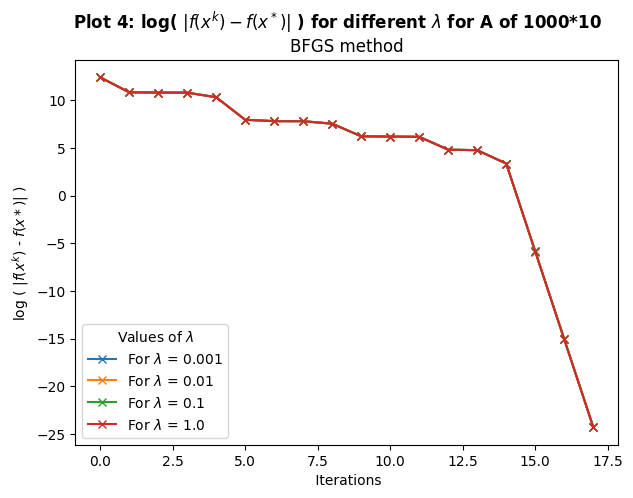

In [31]:
f_opt_bfgs2 = [f_array_bfgs[i][-1] for i in range(len(lambda_values))]
plot_fx_bfgs2 = [[] for _ in range(len(lambda_values))]
for i in range(len(lambda_values)):
    for j in range(len(f_array_bfgs[i])):
        plot_fx_bfgs2[i].append(np.log(np.linalg.norm(f_array_bfgs[i][j] - f_opt_bfgs2[i])))
###Plotting###
fig, ax = plt.subplots(1, 1, figsize = (7,5))
fig.suptitle("Plot 4: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_values)):
    ax.plot(np.arange(len(f_array_bfgs[i])), plot_fx_bfgs2[i], 'x-', label = f"For $\lambda$ = {lambda_values[i]}")
ax.set_title("BFGS method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')


**Question 5:** Both Newton's method and BFGS method produce solutions, $x^*$, and $\bar{x}$, that are nearly identical within the given precision of error for all the provided $\lambda$ values. However, the discrepancy between $x^*$ and $\bar{x}$ increases as we raise the $\lambda$ values.

The optimal solution, $x^*$, differs between Newton's method and BFGS method for all the provided $\lambda$ values due to the regularization term introduced in the main function.

Plotting the logarithm of the Euclidean norm of $\|x^k - x^*\|$ against iterations for both Newton's method and BFGS method reveals a quadratic-linear relationship for all given $\lambda$ values. The distinction lies in the fact that Newton's method exhibits quadratic-linear behavior from the outset, whereas BFGS method demonstrates this behavior after only two iterations.

Similarly, plotting the logarithm of $|f(x^k) - f(x^*)|$ against iterations for both methods yields the same behavior as the plot of $\|x^k - x^*\|$, albeit with different scaling on the axes.

Overall, Newton's method outpaces BFGS method in terms of convergence speed, as it demonstrates quadratic-linear behavior from the beginning, while BFGS method achieves this behavior after a few initial iterations.


$\large\textbf{Answer 6.}$

**Using Newton's Method**

$\lambda$ | $x^*$ |$\bar{x}$ | $f(x^*)$|$f(\bar{x})$ | Time
:----:|:---:|:---:|:---:|:---:|:---:
0.001 | (-3.8946358219518213, 6.158177582958033) | (-3.8864520683267783, 6.149324214707549) | 4754.37010610238 | 4755.077913531231 | 0.010154251000130898
0.1 | (-3.8945965053733778, 6.158114664714515) | (-3.8864520683267783, 6.149324214707549) | 4756.998100640705 | 4757.697389081092 | 0.005226085000685998
1.0 | (-3.8942391185106873, 6.157542739927886) | (-3.8864520683267783, 6.149324214707549) | 4780.886505582736 | 4781.510803170738 | 0.004265139001290663
10.0 | (-3.8906688517338135, 6.151829326691304) | (-3.8864520683267783, 6.149324214707549) | 5019.527566433189 | 5019.644944067193 | 0.0037762970005132956
100.0 | (-3.855322930258129, 6.0952730071477506) | (-3.8864520683267783, 6.149324214707549) | 7381.886450401795 | 7400.986353031748 | 0.003730933000042569